#### Problem Statement

The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

Suppose you are working as a Machine Learning Engineer/Data Scientist in an e-commerce company named 'E-Com'. E-Com has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for E-Com to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a Data Scientis/ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

Data sourcing and sentiment analysis Building a recommendation system Improving the recommendations using the sentiment analysis model Deploying the end-to-end project with a user interface


### High Level steps 

* Data Sourcing and Sentiment Analysis

* Building a recommendation system

* Improving the recommendation system using sentiment analysis model

* Deploying the end-to-end project with user interface


In [16]:
# !pip install pyspellchecker

In [1]:
# Import general purpose libraries 
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import warnings

# Import Pre-Processing Tools
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
warnings.filterwarnings("ignore") 

# Set Pandas options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)
pd.set_option("display.precision", 2)

In [ ]:
# nltk packages
import nltk
import ssl

""" Download all nltk packages through external ssl"""
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')



In [10]:
# nltk libraries
from nltk.corpus import stopwords 
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn

In [12]:
# ML Modelling Libraries

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [24]:
# import sklearn
# print(sklearn.__version__) #1.0.2
# print(np.__version__) #1.22.4
# print(pd.__version__) #1.3.5
# print(nltk.__version__) #3.8.1

In [107]:
import os
cwd = os.getcwd()
df_reviews = pd.read_csv(cwd + "/user_reviews.csv", parse_dates= ['reviews_date'])
df_reviews.shape

(30000, 15)

In [117]:
df_reviews.sample(1)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
29575,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,2017-01-25T16:57:13.000Z,NaN,True,4,"Great conditioner in general with quality on par w/ L'Oreal brand. I wish it was as effective as it claims to be since I was so excited to try it thanks to Influenster. I have sensitive hair with oily roots and dry ends from curling iron, blow dryer, etc. So I was expecting this to work and save...",Smells Great; A Little Goes A Long Way!,Yonkers,NaN,skyy,Positive


In [118]:
#Inspect the dataframe to understand the given data
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

* There are many columns with NULL values, we will handle them later.
* First step is to eliminate some columns as part of our analysis for Sentiment and Recommender models.We will inspect them and remove them later.

### Exploratory Data Analysis(EDA) - Data Cleaning and Pre-Processing

In [120]:
def calc_missing_rowcount(df):
    columns = df.columns
    null_count = [df[col].isnull().sum() for col in columns]
    null_perc = [round((val/df.shape[0]) * 100,2) for val in null_count]
    _df = pd.DataFrame({'Columns':np.array(columns),
                        'Count': np.array(null_count),
                        'Percent':np.array(null_perc)})
    # If round is not an option, formatting options in pandas and numpy will 
    # pd.options.display.float_format = '{:.2f}'.format
    # np.set_printoptions(suppress=True)
                            
    return _df.sort_values("Percent",ascending=False)
calc_missing_rowcount(df_reviews)



,Columns,Count,Percent
12,reviews_userProvince,29830,99.43
11,reviews_userCity,28071,93.57
6,reviews_didPurchase,14068,46.89
7,reviews_doRecommend,2570,8.57
10,reviews_title,190,0.63
3,manufacturer,141,0.47
13,reviews_username,63,0.21
5,reviews_date,46,0.15
0,id,0,0.00
1,brand,0,0.00


#### Observations:
**reviews_userProvince** and **reviews_userCity** have over 93% NULL values and are not useful for analysis. We will remove them from the dataset.

**reviews_didPurchase** column has over 46% NULL values. This field is not useful in building either Sentiment/Recommender system as well and will be removed.

Removing reviews_userProvince, reviews_userCity and reviews_didPurchase from the dataset¶


In [121]:
df_clean = df_reviews.copy()
df_clean.drop(columns=['reviews_userProvince','reviews_userCity','reviews_didPurchase'],
                inplace=True)
df_clean.shape

(30000, 12)

Checking reviews_doRecommend column¶


In [122]:
print(df_clean.reviews_doRecommend.value_counts()
)
print(df_clean.reviews_doRecommend.value_counts(normalize=True)
)

True     25880
False     1550
Name: reviews_doRecommend, dtype: int64
True    0.94
False   0.06
Name: reviews_doRecommend, dtype: float64


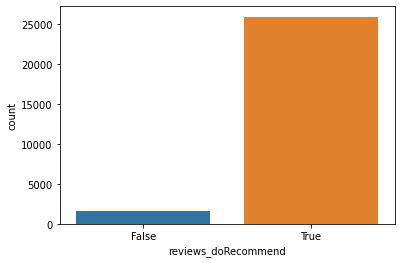

In [123]:
sns.countplot(x = 'reviews_doRecommend', data = df_clean)
plt.show()

Looking at the distribution of reviews_doRecommend column, we can see that more than 94% of the data is having True value. Hence, the column does not provide any useful information for the model to learn. We will drop this field

In [124]:
df_clean.drop(columns=['reviews_doRecommend'], inplace=True)


In [125]:
df_clean.shape

(30000, 11)

**Handling NULL values in reviews_title**

This column is an important component for our analysis as it contains the title of the review given by the user to a particular product. Since the NULL percentage is only 0.633%, we will remove these rows from the dataset.





In [126]:
df_clean = df_clean[~ df_clean.reviews_title.isna() ]
df_clean.shape


(29810, 11)

**Handling NULL values in reviews_username**

This column is an important component for our analysis as it contains the unique identification for individual user in the dataset. Since the NULL percentage is only 0.20%, we will remove these rows from the dataset.

In [127]:
df_clean = df_clean[~ df_clean.reviews_username.isna() ]
df_clean.shape

(29748, 11)

**Handling NULL values in user_sentiment**

In [128]:
df_clean.user_sentiment.value_counts()


Positive    26412
Negative     3335
Name: user_sentiment, dtype: int64

In [129]:
df_clean[ df_clean.user_sentiment.isna() ]


,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),2014-11-07T00:00:00.000Z,5,my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the poin...,a super hit with my children. they loved it!!??,7.87E+11,NaN


As there is only one record with missing data for user_sentiment, we will read the record manually and update the value.

From reading the review title and rating, we can see that the overall sentiment is positive. So, we will update the value as Positive for this particular record with NaN.

In [130]:
df_clean.user_sentiment.fillna('Positive', inplace=True)


As the columns manufacturer and reviews_date are not needed for both Sentiment and Recommender models we don't need to handle the NULL values for them.

In [142]:
# Check the data for top 5 rows
df_clean.sample(1)

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
23365,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",Test,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,2015-05-18T00:00:00.000Z,4,I had to get it. Its a new take on the classic version. I love blu-ray and a free digital copy. WOW,GODZILLA,amazing,Positive


#### Target Analysis

In [143]:
# map the categorical user_sentiment to numerical 1 or 0 for modelling
df_clean['user_sentiment'] = df_reviews['user_sentiment'].map({'Positive':1,'Negative':0})

<AxesSubplot:xlabel='user_sentiment', ylabel='count'>

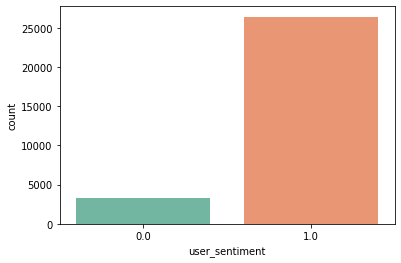

In [156]:
sns.countplot(x='user_sentiment',
              data=df_clean,
              palette='Set2')

In [160]:
df_clean.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_username',
       'user_sentiment'],
      dtype='object')

In [192]:
from collections import Counter
brands_dict = dict(Counter(df_clean['brand']))
brands_count= {key: value for key, value in sorted(brands_dict.items(), 
               key=lambda item: item[1], reverse=True)}
    

brands_count

{'Clorox': 10564,
 'Warner Home Video': 3324,
 'Disney': 1197,
 "L'oreal Paris": 1186,
 'FOX': 887,
 "Burt's Bees": 881,
 'Sony Pictures': 845,
 'Summit Entertainment': 813,
 'Nexxus': 691,
 'Universal Home Video': 668,
 'Olay': 637,
 'Warner Bros.': 458,
 'Lundberg': 414,
 'Clear Scalp & Hair Therapy': 370,
 'Hoover': 349,
 'Windex': 348,
 'Avery': 314,
 'Pendaflex': 310,
 'Aveeno': 302,
 'Tostitos': 286,
 'Storkcraft': 264,
 'Vaseline': 253,
 'Just For Men': 224,
 'Warner Music Group': 204,
 'Hormel': 196,
 'Lionsgate': 186,
 "Chester's": 177,
 'Coty': 158,
 'Lysol': 155,
 'Pantene': 154,
 'Pleasant Hearth': 110,
 'Cuisinart': 103,
 'Bisquick': 96,
 'Vicks': 96,
 "L'Oreal Paris": 94,
 'Head & Shoulders': 92,
 'Aussie': 89,
 'Bounce': 87,
 'Banana Boat': 72,
 'Chips Ahoy': 69,
 'Caress': 68,
 'Yes to Carrots': 63,
 'Cheetos': 60,
 'Ragu': 59,
 'TRESemme': 57,
 'Axe': 57,
 'Suave': 50,
 'Meguiars': 49,
 'Orajel': 46,
 "Mrs. Meyer's": 44,
 'Canada Dry': 43,
 'Finish': 42,
 'Sony Music':

<AxesSubplot:xlabel='reviews_rating', ylabel='count'>

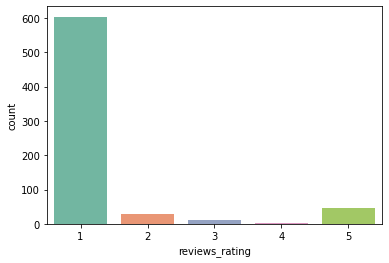

In [194]:
df_nexxus = df_clean[df_clean['brand'] == 'Nexxus']
(sns.countplot(x='reviews_rating', 
              data=df_nexxus,
              palette='Set2') )


<AxesSubplot:xlabel='user_sentiment', ylabel='count'>

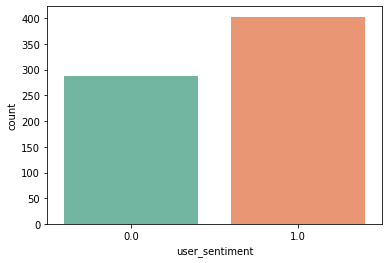

In [195]:
df_nexxus = df_clean[df_clean['brand'] == 'Nexxus']
(sns.countplot(x='user_sentiment', 
              data=df_nexxus,
              palette='Set2') )

In [193]:
# user_sentiment is positive and reviews_rating is less than 4(i.e 3 or less)
df_nexxus[(df_nexxus["user_sentiment"]==1) & (df_nexxus["reviews_rating"]<4)][["brand","reviews_title","reviews_text", "reviews_rating"]].sample(3)


,brand,reviews_title,reviews_text,reviews_rating
21751,Nexxus,Bring back the old formula,"I have been using this for many years and loved it. However, the new formula smells terrible and the hold is not as strong... what happened Bring back the old formula. I have started looking for alternative products.",2
21143,Nexxus,Poo,Have been using Nexxus sculpting gel for maybe 3/4 years and now in 2017 you changed your formula and I don't appreciate the product any longer. New formula makes my hair stiff and difficult to comb and style after use. Want to know how could I possibly get the old product back as it was perfect...,1
21222,Nexxus,Terribly Disappointed!,I've relied on the old formula for 20 years to create body for my baby-fine straight hair. The new formula does not do the trick. I'll have to try other brands until I find a gel comparable to the old formula.,1


In [196]:
pd.crosstab(df_nexxus['user_sentiment'], df_nexxus['reviews_rating'], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0.0,272,12,2,1,1,288
1.0,331,17,8,3,44,403
All,603,29,10,4,45,691


In [197]:
pd.crosstab(df_clean['user_sentiment'], df_clean['reviews_rating'], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0.0,585,137,217,548,1848,3335
1.0,776,272,1115,5444,18805,26412
All,1361,409,1332,5992,20653,29747


As per the above results, there looks to be mismtach between review_rating and user_sentiment. there are records that have higher user rating but user sentiment is negative and lower user rating but user sentiment is positive. We can either clean up those records or update the target column to the correct user sentiment, so that will be helpful for modelling. Here, updating the user_sentiment to 0 (but was 1) when the reviews_rating is less than 4, and updating the user_sentiment to 1(but was 0), when the reviews_rating is greater than or equal to 4

In [198]:
"""
Updating the user_sentiment so that its relevant to the model
Part of pre-processing
"""


df_clean.loc[(df_clean["user_sentiment"]==1) & (df_clean["reviews_rating"]<4), "user_sentiment"] = 0
df_clean.loc[(df_clean["user_sentiment"]==0) & (df_clean["reviews_rating"]>=4), "user_sentiment"] = 1

pd.crosstab(df_clean['user_sentiment'], df_clean['reviews_rating'], margins=True)


reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0.0,1361,409,1332,0,0,3102
1.0,0,0,0,5992,20653,26645
All,1361,409,1332,5992,20653,29747


### Training Analysis


Checking Distribution of *reviews_rating* column¶


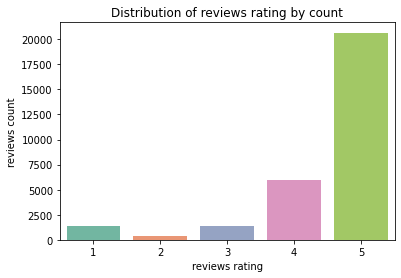

In [144]:
sns.countplot(x = 'reviews_rating', 
              data = df_clean,
              palette= 'Set2').set(title="Distribution of reviews rating by count", 
                                                         xlabel="reviews rating", 
                                                         ylabel="reviews count")
plt.show()


Most of the ratings from the users have been on the higher side. Most of the review ratings have been 5. This would surely cause a data imbalance as user_sentiment should be in alignment with the ratings. We will check and handle it later on.

**Checking Top 5 Brands with negative reviews**

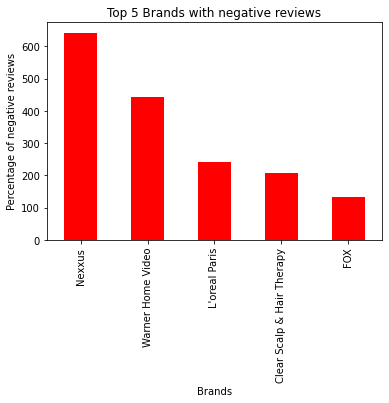

In [202]:
df_clean[ df_clean.user_sentiment == 0].groupby('brand')['brand'].count().sort_values(ascending=False)[:5].plot(kind='bar',color='red')
plt.title("Top 5 Brands with negative reviews")
plt.xlabel("Brands")
plt.ylabel("Percentage of negative reviews")
plt.show()

**Clorox** is the product that is rated the most negative and nearly 30% of the negative reviews have been towards Clorox.



#### Checking Top 5 Brands with positive reviews¶


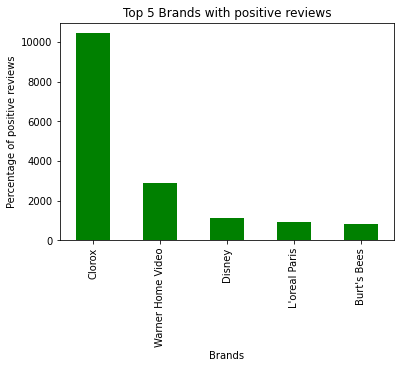

In [201]:
df_clean[ df_clean.user_sentiment == 1 ].groupby('brand')['brand'].count().sort_values(ascending=False)[:5].plot(kind='bar',color='green')
# df_clean[ df_clean.user_sentiment == 0 ].brand.value_counts(normalize=True, ascending=False).head(5).plot(kind='bar')

plt.title("Top 5 Brands with positive reviews")
plt.xlabel("Brands")
plt.ylabel("Percentage of positive reviews")
plt.show()

<AxesSubplot:xlabel='manufacturer'>

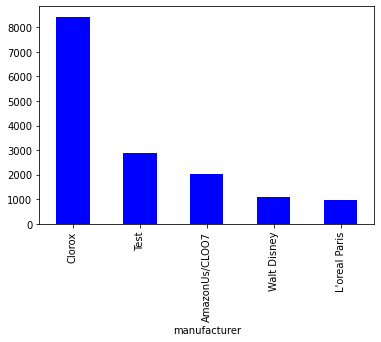

In [206]:
df_clean[ df_clean.user_sentiment == 1 ].groupby('manufacturer')['manufacturer'].count().sort_values(ascending=False)[:5].plot(kind='bar',color='blue')


In [151]:
df_clean.brand.value_counts(normalize=True).head(5)


Clorox              0.36
Warner Home Video   0.11
Disney              0.04
L'oreal Paris       0.04
FOX                 0.03
Name: brand, dtype: float64

* Surprisingly Clorox is the product that is rated the most positive as well and more than 35% of the positive reviews have been towards Clorox.

* Checking the data, we realize that 35% of the brands for which we have the data is actually Clorox which is why it has the most reviews.

#### Type Conversion
Before we start the pre-processing steps, we need to make sure that all the text columns are converted to string type for future text operations.


In [152]:
# Convert all the text columns to string for performing text operations

columns_to_str = ['brand', 'categories', 'manufacturer', 'name',
                  'reviews_text', 'reviews_title', 'reviews_username']
for column in columns_to_str:
    df_clean[column] = df_clean[column].astype(str)
df_clean.sample(2)


,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
8924,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Clea...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,2015-01-09T21:38:14.000Z,5,teacher really appreciates it when I send them to school This review was collected as part of a promotion.,Schools,lilang8833,1.00
3439,AVpe5s3RLJeJML43x4eA,Pantene,"Personal Care,Hair Care,Conditioner,Beauty,Shampoo & Conditioner,Conditioners,Back To College,Ways To Shop,See more Pantene Expert Pro-v Age Defy Conditioner 8oz ...",Pantene Pro-V Hair Care,Pantene Pro-V Expert Collection Age Defy Conditioner,2016-05-10T00:00:00.000Z,5,"I've been using Age Defy - Pantene Expert Collection conditioner for 2 weeks now and my hair is literally coming back to life! It feels so soft and is shining now and also feels stronger, the conditioner is super tick creamy and i use a lot less amount than i used to with another competitive bra...",Age Defy - Pantene Expert Collection Conditioner,mandre86,1.00


### Pre - Processing

In [215]:
# Get a copy of dataframe for pre-processing
df_prep = df_clean.copy(deep=True)
df_prep.sample(1)

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28110,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),2014-11-07T00:00:00.000Z,5,My son just turned 3 - saw it in the theater and of course had to buy it. He is an active kid who can't sit still yet he sits start to finish for this movie!,Engaging family movie action!,jhosborne,1.00


Combining reviews_text and reviews_title columns into reviews_combined and dropping the initial fields

In [216]:
df_prep['reviews_combined'] = df_prep['reviews_text'] + " " + df_prep['reviews_title'] + "."
df_prep.drop(columns=['reviews_text', 'reviews_title'], inplace=True)

In [217]:
df_prep.shape

(29748, 10)

In [218]:
df_prep.sample()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_username,user_sentiment,reviews_combined
8917,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Clea...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,2015-01-04T20:09:19.000Z,5,lovey83,1.00,i love Clorox because it great to clean with it does all the things I need it to do. This review was collected as part of a promotion. Love.



**Removing columns unneeded for analysis**

In [219]:
df_prep.drop(columns=['categories', 'manufacturer', 'reviews_date'], inplace=True)


In [221]:
df_prep.sample()

,id,brand,name,reviews_rating,reviews_username,user_sentiment,reviews_combined
15588,AVpf5Z1zLJeJML43FpB-,Lysol,"Lysol Concentrate Deodorizing Cleaner, Original Scent",3,iabfpm,0.00,"The original scent should come with a warning. After weeks of flu in our house, and my son got his second bout of flu this season (yes, you can get both type A and type B in one season), I was determined to clean every surface in this house. I had several tubs of wonderful Lysol wipes, and was e..."


**Creating dataframe for Sentiment analysis with only the required columns**

In [222]:
df_sent = df_prep[['id','name','reviews_combined', 'user_sentiment']]


In [223]:
df_sent.shape

(29748, 4)

In [225]:
df_sent.sample()

,id,name,reviews_combined,user_sentiment
10768,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Love the smell and it is so easy to use. I like to take these to work and clean up messes. This review was collected as part of a promotion. Awesome.,1.00


**Handling punctuations**